In [108]:
#installing PyAthena for Sagemaker Athena connectivity
import sys
!{sys.executable} -m pip install PyAthena

You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [109]:
#importing other necessary python libraries
from pyathena import connect
import pandas as pd
import boto3

In [110]:
#JDBC connection to connect to Athena 
conn = connect(s3_staging_dir='s3://cs498dataset/test/',
               region_name='us-east-1')

In [111]:
conn

In [112]:
#populate the Pandas data frames from Athena tables - limiting to samplevariants and subset of rows due to cost constaints
df = pd.read_sql("SELECT * FROM demo.samplevariants where referenceallele in ('G','C','A','T','CA','CT','AT') and alternateallele in ('G','C','A','T','CA','CT','AT') and sampleid like 'NA%' limit 1000000;", conn)

In [113]:
df.head()

,alternateallele,chromosome,endposition,genotype0,genotype1,referenceallele,sampleid,startposition
0,T,22,39346452,0,1,C,NA19198,39346451
1,G,22,39363830,1,1,A,NA18621,39363829
2,G,22,39363830,1,1,A,NA19121,39363829
3,G,22,39363830,0,1,A,NA19819,39363829
4,G,22,39363830,1,1,A,NA20899,39363829


In [114]:
#import PCA library from scikitlearn
from sklearn.decomposition import PCA

In [115]:
#checking candidate fields for data pre-processing
df["alternateallele"].value_counts()

C     259100
A     246139
G     241718
T     235909
CA      6418
CT      6006
AT      4710
Name: alternateallele, dtype: int64

In [116]:
#checking candidate fields for data pre-processing
df["referenceallele"].value_counts()

C     267838
G     260369
A     228693
T     221864
CT      8056
CA      7150
AT      6030
Name: referenceallele, dtype: int64

In [117]:
#data preprocessing - replace categorical variable values with integers: reference - https://pbpython.com/categorical-encoding.html
cleanup_nums = {"alternateallele":     {"G": 1, "C": 2,"A": 3,"T": 4,"CA" : 5, "CT":6, "AT":7}, "referenceallele": {"G": 1, "C": 2,"A": 3,"T": 4,"CA" : 5, "CT":6, "AT":7}, }
df.replace(cleanup_nums, inplace=True)
df.head()

,alternateallele,chromosome,endposition,genotype0,genotype1,referenceallele,sampleid,startposition
0,4,22,39346452,0,1,2,NA19198,39346451
1,1,22,39363830,1,1,3,NA18621,39363829
2,1,22,39363830,1,1,3,NA19121,39363829
3,1,22,39363830,0,1,3,NA19819,39363829
4,1,22,39363830,1,1,3,NA20899,39363829


In [118]:
#data pre-processing - strip characters from sampleid field
df['sampleid'] = df['sampleid'].map(lambda x: x.lstrip('NA'))
#data pre-processing - remove chromosomeid field as all the rows will have same value and hence will be insignificant for PCA
X = df = df.drop('chromosome', axis=1)

In [119]:
df.head()

,alternateallele,endposition,genotype0,genotype1,referenceallele,sampleid,startposition
0,4,39346452,0,1,2,19198,39346451
1,1,39363830,1,1,3,18621,39363829
2,1,39363830,1,1,3,19121,39363829
3,1,39363830,0,1,3,19819,39363829
4,1,39363830,1,1,3,20899,39363829


In [120]:
#perform PCA transformation; reduce to 3 principle components and reconstruct original from these 3
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X) #pca transform
X_new = pca.inverse_transform(X_pca) #inverse pca transform
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
print("reconstructed shape:", X_new.shape)

original shape:    (1000000, 7)
transformed shape: (1000000, 3)
reconstructed shape: (1000000, 7)


Text(0.5,1,'Raw Data - 2D plot of first 2 Cols')

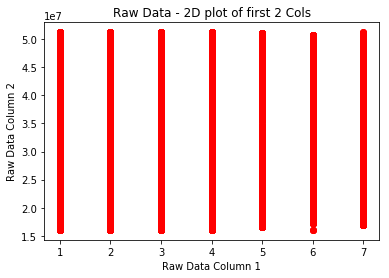

In [127]:
#plotting
import matplotlib.pyplot as plt
import numpy as np
X = np.array(X).astype(np.float32)
x = X[:, 0]
y = X[:, 1]
plt.scatter(x, y,c = 'r')
plt.xlabel('Raw Data Column 1', fontsize=10)
plt.ylabel('Raw Data Column 2', fontsize=10)
plt.title("Raw Data - 2D plot of first 2 Cols")
#plt.axis('equal');

Text(0.5,1,'PCA Transformed data - 2D plot of first 2 Components')

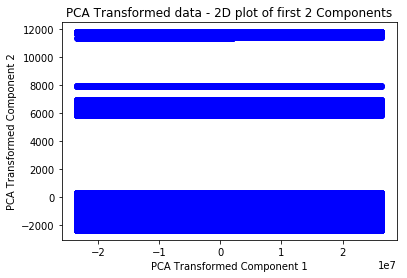

In [128]:
#plotting
plt.scatter(X_pca[:, 0], X_pca[:, 1],c = 'b')
plt.xlabel('PCA Transformed Component 1', fontsize=10)
plt.ylabel('PCA Transformed Component 2', fontsize=10)
plt.title("PCA Transformed data - 2D plot of first 2 Components")
#plt.axis('equal');

Text(0.5,1,'Reconstructed from PCA  - 2D plot of first 2 Cols')

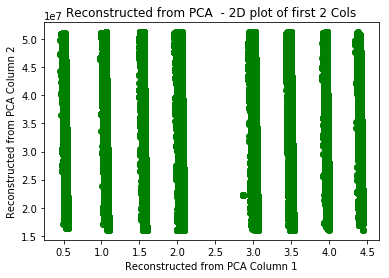

In [129]:
#plotting
plt.scatter(X_new[:, 0], X_new[:, 1],c = 'g')
plt.xlabel('Reconstructed from PCA Column 1', fontsize=10)
plt.ylabel('Reconstructed from PCA Column 2', fontsize=10)
plt.title("Reconstructed from PCA  - 2D plot of first 2 Cols")
#plt.axis('equal');

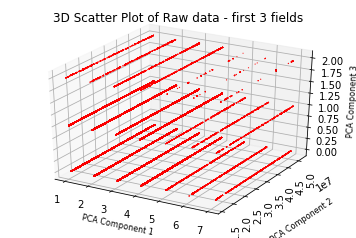

In [130]:
#plotting
from mpl_toolkits.mplot3d import Axes3D  

import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


xs = X[:, 0]
ys = X[:, 1]
zs = X[:, 2]

col = 'r'

ax.scatter(xs, ys, zs, c = col,marker='^', s = .1)

ax.set_xlabel('PCA Component 1',fontsize = 8)
ax.set_ylabel('\n\n\n PCA Component 2',fontsize = 8)
ax.set_zlabel('PCA Component 3',fontsize = 8)
plt.yticks(rotation=90)
plt.title('3D Scatter Plot of Raw data - first 3 fields')
plt.show()

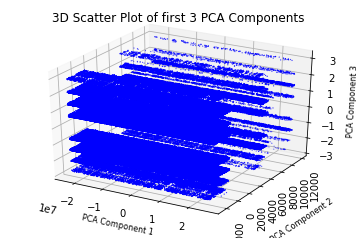

In [131]:
#plotting
from mpl_toolkits.mplot3d import Axes3D  

import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


xs = X_pca[:, 0]
ys = X_pca[:, 1]
zs = X_pca[:, 2]

col = 'b'

ax.scatter(xs, ys, zs, c = col,marker='^', s = .1)

ax.set_xlabel('PCA Component 1',fontsize = 8)
ax.set_ylabel('\n\n\n PCA Component 2',fontsize = 8)
ax.set_zlabel('PCA Component 3',fontsize = 8)
plt.yticks(rotation=90)
plt.title('3D Scatter Plot of first 3 PCA Components')
plt.show()

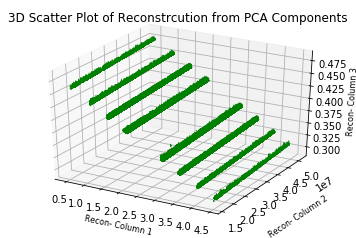

In [132]:
#plotting
from mpl_toolkits.mplot3d import Axes3D  

import matplotlib.pyplot as plt
import matplotlib
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



xs = X_new[:, 0]
ys = X_new[:, 1]
zs = X_new[:, 2]

col = 'g'

ax.scatter(xs, ys, zs, c = col,marker='^', s = .1)

ax.set_xlabel('Recon- Column 1',fontsize = 8)
ax.set_ylabel('\n\nRecon- Column 2',fontsize = 8)
ax.set_zlabel('Recon- Column 3',fontsize = 8)
plt.title('3D Scatter Plot of Reconstrcution from PCA Components')
plt.show()